# Predicting Bike Rentals

In this project, we will predict the total number of bikes people rented in a given hour, `cnt`.

The data we used is compiled by Hadi Fanaee-T at the [University of Porto](https://sigarra.up.pt/up/pt/web_base.gera_pagina?p_pagina=home) into a CSV file. It contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. The data is available [here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


In [3]:
# no missing data
bike_rentals.isna().sum().sum()

0

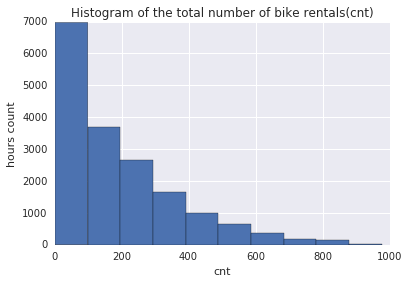

In [4]:
plt.hist(bike_rentals['cnt'])
plt.title('Histogram of the total number of bike rentals(cnt)')
plt.xlabel('cnt')
plt.ylabel('hours count')

The histogram shows the total number of bike rentals is skewed to the right. Most of the value concentrate in the first group, 0-100.

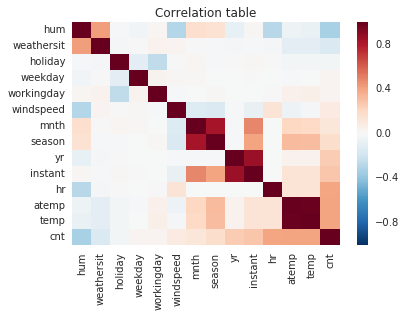

In [5]:
## Correlation with cnt
# drop casual and registered since cnt is the sum of them
corr_col = bike_rentals.columns.drop(['casual', 'registered'])
corr_order = bike_rentals[corr_col].corr()['cnt'].sort_values().index
sns.heatmap(bike_rentals[corr_order].corr())
plt.title('Correlation table')

`temp`, `atemp` and `hr` have quite strong correlation with `cnt`. Meanwhile, `temp` and `atemp` are strongly correlated to each other. On the other hand, `hum` has a negative correlation to `cnt`. We can imagin that more rental is observed when the weather is good and less in bad weather, such as rainy day. So we keep features with an absolute correlation >0.3.

In [6]:
selected_features = ['hr', 'temp', 'atemp', 'hum']

## Feature engineering

The `hr` column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

In [7]:
def assign_label(value):
    # 4 if the hour is from 0 to 6
    if value <=6: return 4
    # 1 if the hour is from 6 to 12
    elif value <=12: return 1
    # 2 if the hour is from 12 to 18
    elif value <=18: return 2
    # 3 if the hour is from 18 to 24
    else: return 3 

In [8]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
selected_features.append('time_label')
selected_features.remove('hr')

## Modeling

We will type with different models to predict `cnt`.

In [9]:
# splitting train and test set
train, test = train_test_split(bike_rentals, 
                               test_size=0.2,
                               random_state=1)

### Linear Regression

In [10]:
lr = LinearRegression()
lr.fit(train[selected_features], train['cnt'])
prediction = lr.predict(test[selected_features])

rmse = np.sqrt(mean_squared_error(test['cnt'], prediction))
rmse

140.69976466564344

### Decision Tree

Then we will use decision tree to predict `cnt`.

In [11]:
# default classifier
dtc = DecisionTreeClassifier()

dtc.fit(train[selected_features], train['cnt'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [12]:
prediction = dtc.predict(test[selected_features])

rmse = np.sqrt(mean_squared_error(test['cnt'],prediction))
rmse

177.86418578392892

In [13]:
# classifier with min_samples_leaf
for i in [2,5,10]:
    dtc = DecisionTreeClassifier(min_samples_leaf = i)

    dtc.fit(train[selected_features], train['cnt'])
    prediction = dtc.predict(test[selected_features])

    rmse = np.sqrt(mean_squared_error(test['cnt'],prediction))
    print('rmse of {} min_samples_leaf: {}'.format(i, rmse))

rmse of 2 min_samples_leaf: 179.72978695143007
rmse of 5 min_samples_leaf: 184.78187542198208
rmse of 10 min_samples_leaf: 186.5951407399347


The results are worse than the default model.

### Random Forest

In [14]:
# default classifier
rfc = RandomForestClassifier()

rfc.fit(train[selected_features], train['cnt'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [15]:
prediction = rfc.predict(test[selected_features])

rmse = np.sqrt(mean_squared_error(test['cnt'],prediction))
rmse

172.56867097631496

In [19]:
# classifier with min_samples_leaf
for i in [2,5,10]:
    rfc = RandomForestClassifier(min_samples_leaf=i, max_depth= 100)
    rfc.fit(train[selected_features], train['cnt'])
    
    prediction = rfc.predict(test[selected_features])
    rmse = np.sqrt(mean_squared_error(test['cnt'],prediction))
    print('rmse of {} min_samples_leaf: {}'.format(i, rmse))

rmse of 2 min_samples_leaf: 168.4220657528315
rmse of 5 min_samples_leaf: 166.39985135012614
rmse of 10 min_samples_leaf: 174.5559218428374


# Summary

We have tested 3 models, linear regression, decision tree and random forest and linear regression provides the best accuracy among all.